In [27]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [28]:
cd /content/gdrive/My Drive/

/content/gdrive/My Drive


In [0]:
from scipy.io import loadmat
import numpy as np
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import os
import cv2
import matplotlib.pyplot as plt
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import TensorBoard

In [38]:
row = 180
col = 180
datab = np.empty([200,row,col,3], dtype = np.uint8)
dataf = np.empty([200,row,col,3], dtype = np.uint8)
datan = np.empty([200,row,col,3], dtype = np.uint8)
datao = np.empty([200,row,col,3], dtype = np.uint8)
path = './train'
for i in range(200):
    if i%20 ==0:
      print(i)
    imgb = mpimg.imread(path+ "/" + str(i + 1)+'b.jpg')
    imgb = cv2.resize(imgb, dsize=(row, col))
    imgf = mpimg.imread(path + "/" + str(i + 1)+'f.jpg')
    imgf = cv2.resize(imgf, dsize=(row, col))
    imgn = mpimg.imread(path + "/" + str(i + 1)+'n.jpg')
    imgn = cv2.resize(imgn, dsize=(row, col))
    imgo = mpimg.imread(path + "/" + str(i + 1)+'o.jpg')
    imgo = cv2.resize(imgo, dsize=(row, col))    
    datab[i] = imgb.reshape(row,col,3)
    dataf[i] = imgf.reshape(row,col,3)
    datan[i] = imgn.reshape(row,col,3)
    datao[i] = imgo.reshape(row,col,3)

0
20
40
60
80
100
120
140
160
180


In [39]:
ratio = 0.75
slc = int(ratio * datab.shape[0])
x_train = datan[:slc]
y_train = datao[:slc]
x_test = datan[slc:]
y_test = datao[slc:]
x_train=x_train.astype('float32')/255.
y_train=y_train.astype('float32')/255.
x_test=x_test.astype('float32')/255.
y_test=y_test.astype('float32')/255.

y_train.shape

(150, 180, 180, 3)

In [40]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
from tensorflow.keras.optimizers import Adam
with tf.device('/device:GPU:0'):
  input_img = layers.Input(shape=(row, col, 3))  # adapt this if using `channels_first` image data format
  x_shortcut = input_img
  x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
  x = layers.MaxPooling2D((2, 2), padding='same')(x)
  x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  #x = layers.MaxPooling2D((2, 2), padding='same')(x)

  x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  #x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
  x = tf.add(x_shortcut, x)
  output = layers.Dense(3, activation='relu')(x)
  ODP = models.Model(input_img, output)
  ODP.compile(optimizer=Adam(lr=0.003), loss='binary_crossentropy')

In [74]:
print(ODP.summary())

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 180, 180, 64) 1792        input_16[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 90, 90, 64)   0           conv2d_75[0][0]                  
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 90, 90, 64)   36928       max_pooling2d_21[0][0]           
___________________________________________________________________________________________

In [90]:
with tf.device('/device:GPU:0'):
  ODP.fit(x_train, y_train,
                epochs=300,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, y_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 150 samples, validate on 50 samples
Epoch 1/300
150/150 [==============================] - 1s 8ms/sample - loss: 0.5560 - val_loss: 0.5629
Epoch 2/300
150/150 [==============================] - 1s 8ms/sample - loss: 0.5560 - val_loss: 0.5629
Epoch 3/300
150/150 [==============================] - 1s 8ms/sample - loss: 0.5560 - val_loss: 0.5629
Epoch 4/300
150/150 [==============================] - 1s 8ms/sample - loss: 0.5560 - val_loss: 0.5628
Epoch 5/300
150/150 [==============================] - 1s 8ms/sample - loss: 0.5560 - val_loss: 0.5628
Epoch 6/300
150/150 [==============================] - 1s 8ms/sample - loss: 0.5560 - val_loss: 0.5628
Epoch 7/300
150/150 [==============================] - 1s 8ms/sample - loss: 0.5559 - val_loss: 0.5628
Epoch 8/300
150/150 [==============================] - 1s 8ms/sample - loss: 0.5559 - val_loss: 0.5628
Epoch 9/300
150/150 [==============================] - 1s 8ms/sample - loss: 0.5559 - val_loss: 0.5628
Epoch 10/300
150/150 [======

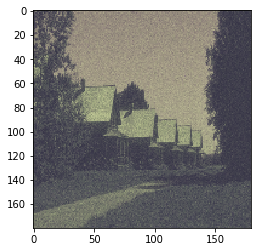

In [81]:
#200 epoch
y_pred = ODP.predict(x_test)
plt.imshow(y_pred[0])

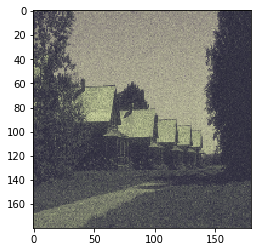

In [83]:
#300 epoch
y_pred = ODP.predict(x_test)
plt.imshow(y_pred[0])

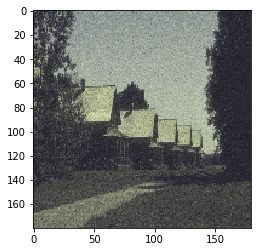

In [85]:
# 500 epoch
y_pred = ODP.predict(x_test)
plt.imshow(y_pred[0])

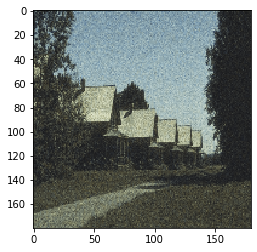

In [87]:
# 800 epoch
y_pred = ODP.predict(x_test)
plt.imshow(y_pred[0])

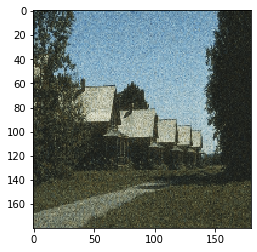

In [89]:
# 1100 epoch
y_pred = ODP.predict(x_test)
plt.imshow(y_pred[0])

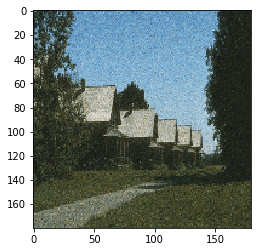

In [91]:
# 1400 epoch
y_pred = ODP.predict(x_test)
plt.imshow(y_pred[0])

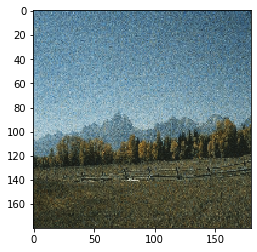

In [92]:
# 1400 epoch
y_pred = ODP.predict(x_train)
plt.imshow(y_pred[0])

In [96]:
with tf.device('/device:GPU:0'):
  ODP.fit(x_train, y_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, y_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 150 samples, validate on 50 samples
Epoch 1/200
150/150 [==============================] - 1s 8ms/sample - loss: 0.5526 - val_loss: 0.5589
Epoch 2/200
150/150 [==============================] - 1s 8ms/sample - loss: 0.5526 - val_loss: 0.5589
Epoch 3/200
150/150 [==============================] - 1s 8ms/sample - loss: 0.5526 - val_loss: 0.5589
Epoch 4/200
150/150 [==============================] - 1s 8ms/sample - loss: 0.5526 - val_loss: 0.5589
Epoch 5/200
150/150 [==============================] - 1s 8ms/sample - loss: 0.5526 - val_loss: 0.5589
Epoch 6/200
150/150 [==============================] - 1s 8ms/sample - loss: 0.5526 - val_loss: 0.5589
Epoch 7/200
150/150 [==============================] - 1s 8ms/sample - loss: 0.5526 - val_loss: 0.5589
Epoch 8/200
150/150 [==============================] - 1s 8ms/sample - loss: 0.5526 - val_loss: 0.5589
Epoch 9/200
150/150 [==============================] - 1s 8ms/sample - loss: 0.5526 - val_loss: 0.5589
Epoch 10/200
150/150 [======

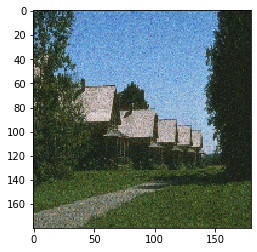

In [94]:
# 2400 epoch
y_pred = ODP.predict(x_test)
plt.imshow(y_pred[0])

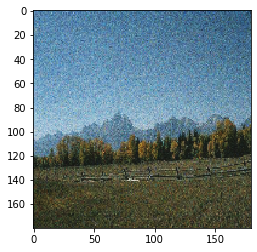

In [95]:
# 2400 epoch
y_pred = ODP.predict(x_train)
plt.imshow(y_pred[0])

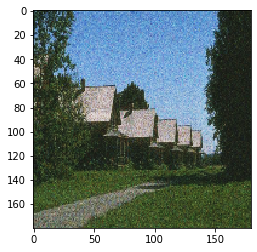

In [97]:
# 2600 epoch
y_pred = ODP.predict(x_test)
plt.imshow(y_pred[0])

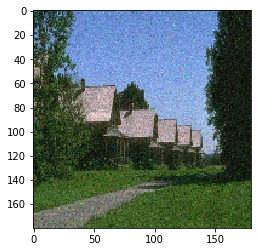

In [77]:
plt.imshow(x_test[0])

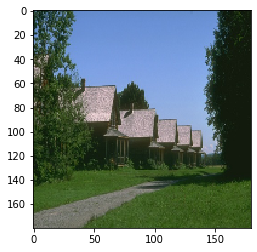

In [63]:
plt.imshow(y_test[0])

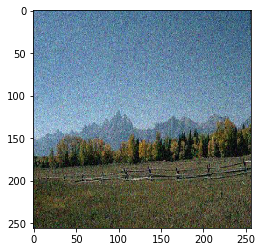

In [0]:
plt.imshow(x_train[0])